In [1]:
from utils import *
import numpy as np
import sys, os, random
import statistics


# from compare_locations import compare_locations

datadir = "../../data.upb/precis/02-precis-redmi-pixel4a/"
pix_etaje = [ "0-pixel-04-06-2021_19-34-41.json.gz"]  
red_etaje = [ "0-redmi-04-06-2021_19-33-47.json.gz"]




In [5]:
# As propune sa dam una din temele de OpenCL modificate ptr CUDA. Cel mai simplu candidat (dar e nevoie de niște tweaks/refactor) ar fi Accessible Population [2], am atasat si enunțul in email. O alta varianta ar mai fi Compresie ETC1 [3] (atasat anuntul in email), însă cred ca ar fi nevoie de mai multă munca aici ptr varianta CUDA.
datadir = "../../data.upb/precis/01-precis-redmi-pixel4a/nowl/"
pix_etaje = [
"0-pixel-04-03-2021_15-32-38.json.gz",
"1-pixel-25-02-2021_21-16-46.json.gz",
"2-pixel-25-02-2021_16-27-45.json.gz",
"3-pixel-04-03-2021_16-18-50.json.gz",
"4-pixel-04-03-2021_16-43-50.json.gz",
"5-pixel-04-03-2021_17-11-32.json.gz",
"6-pixel-17-03-2021_12-52-29.json.gz",
"7-pixel-17-03-2021_13-14-36.json.gz"]

red_etaje = [
"0-redmi-04-03-2021_15-31-12.json.gz",
"1-redmi-25-02-2021_21-16-10.json.gz",
"2-redmi-25-02-2021_16-27-08.json.gz",
"3-redmi-04-03-2021_16-18-52.json.gz",
"4-redmi-04-03-2021_16-43-45.json.gz",
"5-redmi-04-03-2021_17-11-30.json.gz",
"6-redmi-17-03-2021_12-52-29.json.gz",
"7-redmi-17-03-2021_13-14-39.json.gz"]

In [6]:
import numpy as np
from scipy.spatial.distance import *
from scipy.stats import ks_2samp, chisquare
from scipy.optimize import curve_fit
from scipy.linalg import norm
import itertools
import copy 

def real_braycurtis(u, v, ex):
    """
    Compute the Bray-Curtis distance between two 1-D arrays.
    Bray-Curtis distance is defined as
    .. math::
       \\sum{|u_i-v_i|} / \\sum{|u_i+v_i|}
    The Bray-Curtis distance is in the range [0, 1] if all coordinates are
    positive, and is undefined if the inputs are of length zero.
    """
    l1_diff = abs(u - v)
    l1_sum = abs(u + v)
    
    return (abs(ex) + l1_diff.sum()) / (abs(ex) + l1_sum.sum())


def precalculate(c): # c is a collection
    """ creates new fields to speed up distance comparisons 
          c.ufingerprint['wifirssi'][mac] = average dBm 
    """
    ufingerprint = {}
    ufingerprint['wifirssi'] = {}
    for f in c['fingerprints']:
        if not "wifi" in f.keys():
            continue
        for mac in f["wifi"].keys():
            avg_pow = np.average(f["wifi"][mac]['rssi']) # each fingerprint (direction) counts the same
            if not mac in ufingerprint["wifirssi"].keys():
                ufingerprint["wifirssi"][mac] = [avg_pow] 
            else:
                ufingerprint["wifirssi"][mac].append(avg_pow)
    for mac in ufingerprint["wifirssi"].keys():
        ufingerprint["wifirssi"][mac] = \
            np.average(adjust_rssi(ufingerprint["wifirssi"][mac])) #each fingerprint (direction) counts the same
    c['ufingerprint'] = ufingerprint
                
def merge_wifi_fingerprints1(flist):
    if len(flist) == 1:
        return flist[0]
    fingerprint = copy.deepcopy(flist[0])
    for f2 in copy.deepcopy(flist[1:]):
        if not "wifi" in f2.keys():
            continue
        for mac in f2["wifi"].keys():
            if not mac in fingerprint["wifi"].keys():
                fingerprint["wifi"][mac] = f2["wifi"][mac]
            else:
                fingerprint["wifi"][mac]['rssi'].extend(f2["wifi"][mac]['rssi'])
            fingerprint["wifi"][mac]['rssi'].sort()    
    return fingerprint

def compare_locations(c1, c2, simil_method = braycurtis,  selection = 'Average', dif = True):
    # precalculated with average, adjust_rssi  
    wifi1 = c1['ufingerprint']['wifirssi']
    wifi2 = c2['ufingerprint']['wifirssi']      
    
    common_aps = list(set(wifi1.keys()) & set(wifi2.keys()))
    # No APs in common -> similarity = 1
    if not common_aps:
        return 1.0

    if len(common_aps) * 5 <= len(wifi1.keys()) or len(common_aps) < 3:
        return 1.0

    aps1 = set(wifi1.keys()) - set(common_aps)
    aps2 = set(wifi2.keys()) - set(common_aps)
    rssi1 = np.empty(len(common_aps) + len(aps1) + len(aps2), dtype=float)
    rssi2 = np.empty(len(common_aps) + len(aps1) + len(aps2), dtype=float)
    nap = 0   #  
    
    if selection == 'First':
        for ap in common_aps:
            rssi1.append(wifi1[ap]['rssi'][0])
            rssi2.append(wifi2[ap]['rssi'][0])

        # Make an average of all RSSI values
    if selection == 'Average':
        for ap in common_aps:
            rssi1[nap] = wifi1[ap]
            rssi2[nap] = wifi2[ap]
            nap = nap + 1
            
    if selection == 'Median':
        for ap in common_aps:
            rssi1.append(np.median(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.median(adjust_rssi(wifi2[ap]['rssi'])))

    if selection == 'Mean':
        for ap in common_aps:
            rssi1.append(np.mean(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.mean(adjust_rssi(wifi2[ap]['rssi'])))

    if selection == 'Std':
        for ap in common_aps:
            rssi1.append(np.std(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.std(adjust_rssi(wifi2[ap]['rssi'])))

    if selection == 'Max':
        for ap in common_aps:
            rssi1.append(np.max(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.max(adjust_rssi(wifi2[ap]['rssi'])))
            
    if selection == 'KS':
        for ap in common_aps:
            _, p = ks_2samp(wifi1[ap]['rssi'], wifi2[ap]['rssi'])
            rssi1.append(p)
            rssi2.append(1.0)

   
    """
    p1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), wifi1.keys())))
    p2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), wifi2.keys())))
    pc1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), common_aps)))
    pc2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), common_aps)))
    po1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), aps1)))
    po2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), aps2)))        
    iou = len(common_aps) / \
        (len(aps1) + len(aps2) + len(common_aps))
    """
        
    for ap in aps1:
        rssi1[nap] = 1.0*wifi1[ap]
        rssi2[nap] = adjust_rssi(-100.0)[0]
        nap = nap + 1
    for ap in aps2:
        rssi2[nap] = 1.0*wifi2[ap]
        rssi1[nap] = adjust_rssi(-100.0)[0]
        nap = nap + 1

    
    if (dif == True) and (selection != 'KS'):
        if False: # generate onlycertain pairs of diffs 
            if len(rssi1) > nap:
                rssi1[nap] = rssi1[0]
                rssi2[nap] = rssi2[0]
            rssi1 = np.diff(rssi1, append=rssi1[0])  # becomes -1..1
            rssi2 = np.diff(rssi2, append=rssi1[0])   
            #rssi1 = (np.ones(nap) + rssi1)/2
            #rssi2 = (np.ones(nap) + rssi2)/2
            print(f"rssi1={rssi1.round(3)}")
            print(f"rssi2={rssi2.round(3)}")
        else: # generate all possible pairs of diffs 
            allpairs1 = np.array(list(itertools.combinations(rssi1, 2)))
            diff1 = allpairs1[:, 0] - allpairs1[:, 1]
            allpairs2 = np.array(list(itertools.combinations(rssi2, 2)))
            diff2 = allpairs2[:, 0] - allpairs2[:, 1]
            #print(f"rssi1={rssi1.round(3)}")
            #print(f"diff1={diff1.round(3)}")
            return simil_method(diff1, diff2)        
        
    return simil_method(rssi1, rssi2)
    #return rssi1, rssi2




In [8]:
retaje = []
for e in red_etaje: 
    json_file = os.path.join(datadir, e)
    etaj = load_dataset_json(json_file)
    for c in etaj:
        precalculate(c)
    retaje.append(etaj)

petaje = []
for e in pix_etaje: 
    json_file = os.path.join(datadir, e)
    etaj = load_dataset_json(json_file)
    for c in etaj:
        precalculate(c)
    petaje.append(etaj)
    

In [11]:
etaje = petaje
di = compare_locations(etaje[0][0], etaje[0][17], dif=True, simil_method=cosine)
nd = compare_locations(etaje[0][0], etaje[0][1], dif=False, simil_method=cosine)
print(f"di={di.round(3)} nd={nd.round(3)}")

di=1.079 nd=0.018


In [12]:
# compute similarities using neighbors < 7m 
# 

before = datetime.datetime.now()
etaje = retaje 
TP, FP, FN, R = 0, 0, 0, 0  
npct = 400 
fpd, posd = [], []
bd = []
bd_min = []
minra = []

for e in range(0, len(etaje)):
    bc_matrix = np.zeros(shape=(len(etaje[e]), len(etaje[e])))
    bc_matrix_dif_false = np.zeros(shape=(len(etaje[e]), len(etaje[e])))
    eu_dist_matrix = np.zeros(shape=(len(etaje[e]), len(etaje[e])))
    cos_matrix = np.zeros(shape=(len(etaje[e]), len(etaje[e])))
    cos_matrix_dif_false = np.zeros(shape=(len(etaje[e]), len(etaje[e])))
    
    mindisim = 1
    mindist = 100000
    for q in range(0,len(etaje[e])):
        for p in range(q+1,len(etaje[e])):
            if p > q:
                eu_dist = euclidean([etaje[e][q]['x'], etaje[e][q]['y'], etaje[e][q]['z']], 
                                        [etaje[e][p]['x'], etaje[e][p]['y'], etaje[e][p]['z']]) 
                if eu_dist > 12.5: # 12.5m = end of Precis corridor 
                    continue
                bc = compare_locations(etaje[e][q], etaje[e][p], selection = 'Average', \
                                              dif=True, simil_method=braycurtis)
                bc_false = compare_locations(etaje[e][q], etaje[e][p], selection = 'Average', \
                                              dif=False, simil_method=braycurtis)
                cos = compare_locations(etaje[e][q], etaje[e][p], selection = 'Average', \
                                              dif=True, simil_method=cosine)
                if cos > 1.0:
                    print(f"q={q} p={p} dist={eu_dist} cosdi={cos}") 
                cos_false = compare_locations(etaje[e][q], etaje[e][p], selection = 'Average', \
                                              dif=False, simil_method=cosine)
                if cos_false > 1.0:
                    print(f"q={q} p={p} dist={eu_dist} cosnd={cos_false}") 
                
                R, thr = 4.0, 0.1
                if cos < thr: 
                    if eu_dist < R:
                        TP = TP + 1 
                    else:
                        FP = FP + 1
                        fpd.append(eu_dist)
                    posd.append(eu_dist)    
                else:
                    if eu_dist < R:
                        FN = FN + 1
                           
                #print(p,q)
                bc_matrix[p][q] = bc
                bc_matrix[q][p] = bc
                bc_matrix_dif_false[p][q] = bc_false
                bc_matrix_dif_false[q][p] = bc_false
                eu_dist_matrix[p][q] = eu_dist
                eu_dist_matrix[q][p] = eu_dist
                cos_matrix[p][q] = cos
                cos_matrix[q][p] = cos
                cos_matrix_dif_false[p][q] = cos_false
                cos_matrix_dif_false[q][p] = cos_false



                                        
                bd.append([q, p, eu_dist, bc, cos, bc_false, cos_false])
                bd_min.append([q, p, round(eu_dist, 1), round(bc, 3)])
after = datetime.datetime.now()

print(f"R= {R} bc={thr} Precision= {TP*1.0/(TP+FP):.2f} Recall= {TP*1.0/(TP+FN):.2f} \
Pdist = {np.percentile(posd, [50, 95, 99])} ")
m = np.polyfit([r[2] for r in bd] , [r[3] for r in bd], 1)
print(f"Slope = {m[0]:.2f}")

q=14 p=30 dist=12.100198804611065 cosdi=1.0458101708073886
q=3 p=20 dist=12.355983817352403 cosdi=1.0252207604253762
q=4 p=20 dist=11.557211432463909 cosdi=1.0086052194103523
q=15 p=32 dist=12.304396577968745 cosdi=1.0012884304516398
q=16 p=32 dist=11.536604260778924 cosdi=1.0412546612490183
q=16 p=33 dist=12.245294519521465 cosdi=1.0798556838092852
q=32 p=48 dist=12.027616053441095 cosdi=1.0013819487142062
q=4 p=35 dist=11.59580128882191 cosdi=1.0169322203273663
q=4 p=36 dist=10.62919233771156 cosdi=1.0349241372531903
q=4 p=37 dist=9.682882191261232 cosdi=1.0248432227083912
q=6 p=36 dist=11.820459675585747 cosdi=1.0375946192919892
q=6 p=37 dist=10.977328669577426 cosdi=1.0213983156108786
q=7 p=37 dist=11.742446248268722 cosdi=1.1276115400608437
q=7 p=38 dist=10.996584798327776 cosdi=1.0604462144994915
q=7 p=39 dist=10.306603034739542 cosdi=1.0155734695815444
q=7 p=40 dist=9.684452001024468 cosdi=1.0036113518660335
q=8 p=38 dist=11.873606449574432 cosdi=1.0351129528226846
q=8 p=39 dist

In [ ]:
di = compare_locations(etaje[0][0], etaje[0][16], dif=True, simil_method=cosine)
#nd = compare_locations(etaje[0][0], etaje[0][2], dif=False, simil_method=cosine)
print(f"di={di} nd={nd}")

di=0.8405794873573846 nd=0.025969532317177357


Poly fit = [ 2.53063722e+01 -5.09627924e+01  3.80014016e+01  2.58047749e-05]
Curve fit a,b,c = [ 1.43236039 -1.97878302  0.37748918]


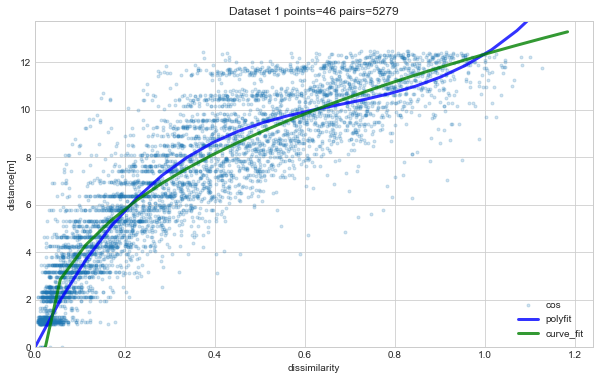

[ 0.25  0.75  1.25  1.75  2.25  2.75  3.25  3.75  4.25  4.75  5.25  5.75
  6.25  6.75  7.25  7.75  8.25  8.75  9.25  9.75 10.25 10.75 11.25 11.75]


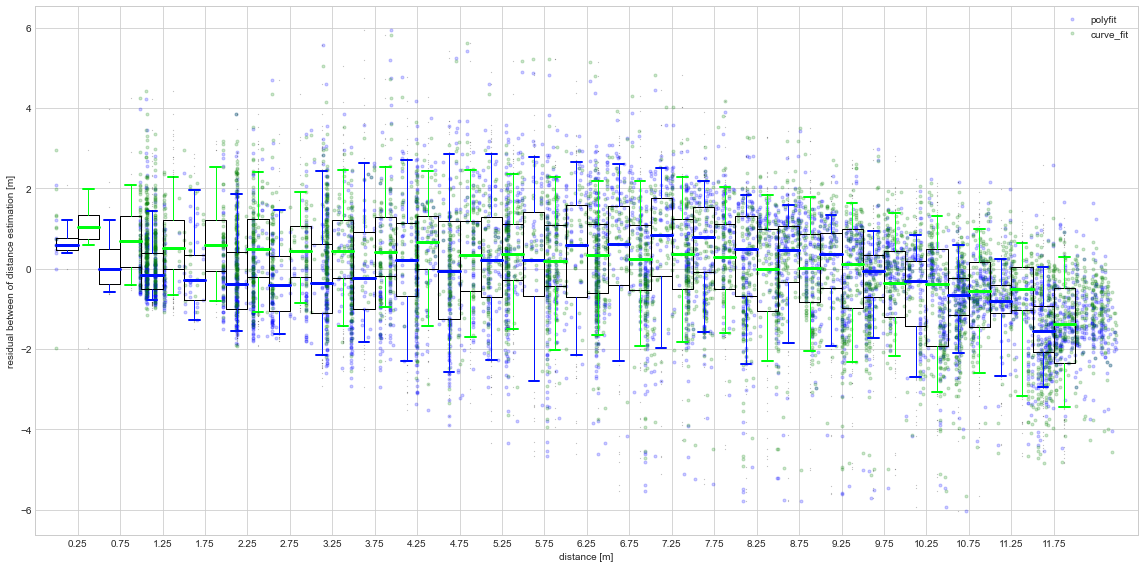

[0.025 0.075 0.125 0.175 0.225 0.275 0.325 0.375 0.425 0.475 0.525 0.575
 0.625 0.675 0.725 0.775 0.825 0.875 0.925 0.975 1.025 1.075]


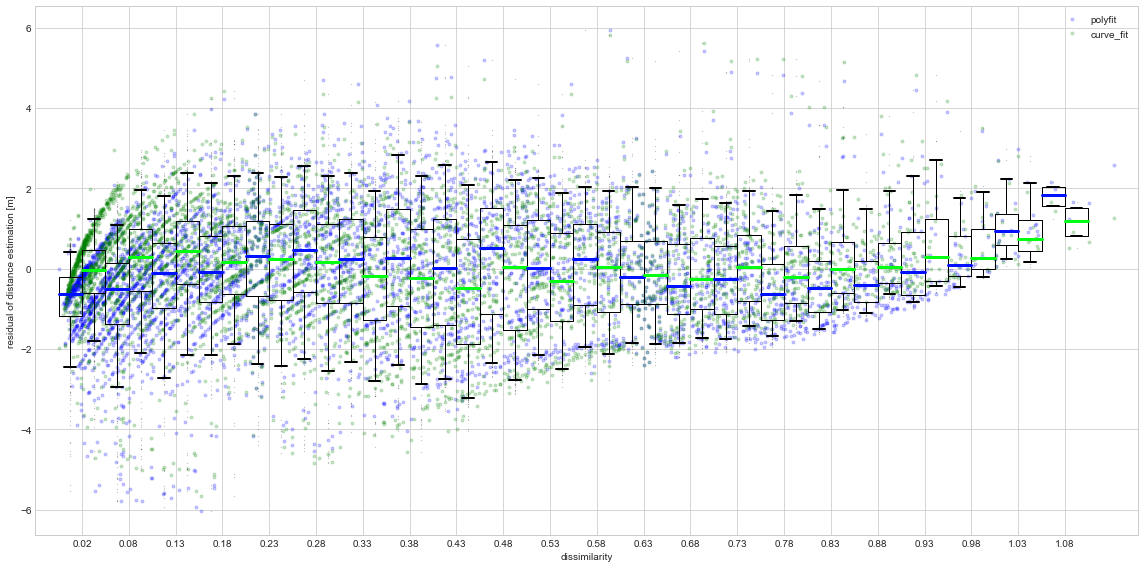

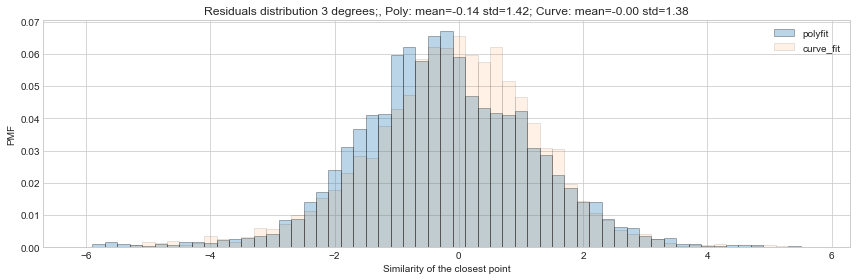

Poly fit = [-1.61378550e-04  6.15940860e-03  1.16794970e-02  1.42452864e-07]
Curve fit a,b,c = [1.49540246e-03 6.24902329e-03 1.57459905e+00]


/tmp/ipykernel_1641932/3454511758.py:4: RuntimeWarning: divide by zero encountered in power
  return b + a * 10 * (x ** (c / 1.0))


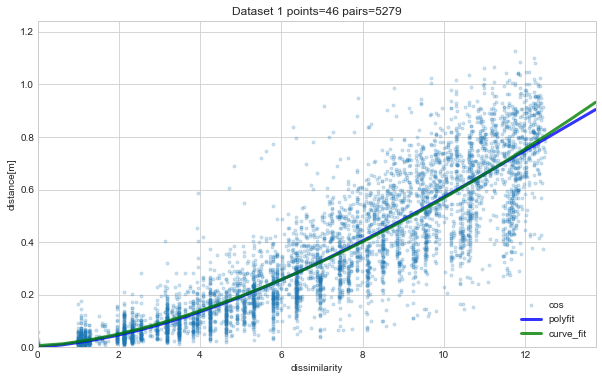

In [13]:


# fit dissimilarity to distance 

def objective(x, a, b, c):
	return b + a * 10 * (x ** (c / 1.0))

dst = [r[2] for r in bd]  # distance 
dis = [r[4] for r in bd]  # 4 = cosine+diff 6=cosine+nodiff 
w = np.ones(len(dis))
dis = np.append(dis, 0)
dst = np.append(dst, 0)
w = np.append(w, len(dis))
degrees = 3

# dissim vs distance 

m = np.polyfit(dis , dst , degrees, w=w)
print(f"Poly fit = {m}")
predict = np.poly1d(m)
x_lin_reg = np.arange(min(dis), max(dis)*1.1, (max(dis) - min(dis))/20.0)
y_lin_reg1 = predict(x_lin_reg)
residuals1 = (predict(dis) - dst)

popt, _ = curve_fit(objective, dis, dst, sigma=w)
a, b, c = popt
print(f"Curve fit a,b,c = {popt}")
y_lin_reg2 = objective(x_lin_reg, a, b, c)
residuals2 = objective(dis, a, b, c) - dst

plt.style.use("seaborn-whitegrid")   
fig =  plt.figure(figsize=(10, 6))      
plt.plot(dis, dst, ".", label='cos', alpha=0.2)
plt.plot(x_lin_reg, y_lin_reg1, c = 'b', alpha=0.8, linewidth=3, label='polyfit')
plt.plot(x_lin_reg, y_lin_reg2, c = 'g', alpha=0.8, linewidth=3, label='curve_fit')
plt.ylabel('distance[m]')
plt.xlabel('dissimilarity')
plt.grid(True)
plt.title(f"Dataset 1 points={len(etaje[0])} pairs={len(bd)}")
plt.ylim(min(dst), max(dst)*1.1)
plt.xlim(min(dis), max(dis)*1.1)
plt.legend(loc="lower right",shadow=True, fancybox=True)                            
plt.show()


# Residuals vs distance 
plt.style.use("seaborn-whitegrid")   
#fig = plt.figure(figsize=(12, 8))
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(dst, (residuals1), ".", c= 'b', alpha=0.2, label='polyfit')
plt.plot(dst, (residuals2), ".", c = 'g', alpha=0.2, label='curve_fit')
binsize = 0.5 # 0.5m bin
bincenters = np.arange(min(dst)+binsize/2, max(dst)-binsize/2, binsize)
print(bincenters)
for b in bincenters:
  pts_ndx = (dst >= b - binsize/2) & (dst <= b + binsize/2)

  ax.boxplot([residuals1[pts_ndx]],
              positions=[b - binsize/4], 
              whis=(5,95),widths=binsize/2,
              flierprops=dict(marker='o', markersize=.10, alpha=0.9), 
              whiskerprops=dict(color='#0011ff', linestyle='-'), 
              capprops = dict(color='#0011ff', linewidth=2),
              medianprops = dict(color='#0011ff', linewidth=3))
  ax.boxplot([residuals2[pts_ndx]],
              positions=[b+binsize/4], 
              whis=(5,95),widths=binsize/2,
              flierprops=dict(marker='o', markersize=.10, alpha=0.9), 
              whiskerprops=dict(color='#00ff11', linestyle='-'), 
              capprops = dict(color='#00ff11', linewidth=2),
              medianprops = dict(color='#00ff11', linewidth=3))
  # ax1.plot([], c='r', label='Redmi')
  # ax1.plot([], c='b', label='Pixel')
ax.legend()

ax.set_xticks(bincenters)
  #np.arange(0, max(y)+binsize, binsize))
  # ax1.set_yticks(np.arange(0, 80, 10))
ax.set_xticklabels(bincenters.round(2))
ax.set_xlim(min(dst)-binsize/2, max(dst)+binsize/2)
  # ax1.set_ylim(10, 80)
ax.set_xlabel("distance [m]")
ax.set_ylabel("residual between of distance estimation [m]")
  # plt.rc('font', size=14) 
fig.tight_layout()
plt.show()





# Residuals vs disim 
plt.style.use("seaborn-whitegrid")   
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(dis, (residuals1), ".", c= 'b', alpha=0.2, label='polyfit')
plt.plot(dis, (residuals2), ".", c = 'g', alpha=0.2, label='curve_fit')
binsize = 0.05 # 0.05 (dis)  bin
bincenters = np.arange(min(dis)+binsize/2, max(dis)-binsize/2, binsize)
print(bincenters)
for b in bincenters:
  pts_ndx = (dis >= b - binsize/2) & (dis <= b + binsize/2)

  ax.boxplot([residuals1[pts_ndx]],
              positions=[b - binsize/4], 
              whis=(5,95),widths=binsize/2,
              flierprops=dict(marker='o', markersize=.10, alpha=0.9), 
              whiskerprops=dict(color='k', linestyle='-'), 
              capprops = dict(color='k', linewidth=2),
              medianprops = dict(color='#0011ff', linewidth=3))
  ax.boxplot([residuals2[pts_ndx]],
              positions=[b+binsize/4], 
              whis=(5,95),widths=binsize/2,
              flierprops=dict(marker='o', markersize=.10, alpha=0.9), 
              whiskerprops=dict(color='k', linestyle='-'), 
              capprops = dict(color='k', linewidth=2),
              medianprops = dict(color='#00ff11', linewidth=3))
  # ax1.plot([], c='r', label='Redmi')
  # ax1.plot([], c='b', label='Pixel')
ax.legend()

ax.set_xticks(bincenters)
  #np.arange(0, max(y)+binsize, binsize))
  # ax1.set_yticks(np.arange(0, 80, 10))
ax.set_xticklabels(bincenters.round(2))
ax.set_xlim(min(dis)-binsize/2, max(dis)+binsize/2)
  # ax1.set_ylim(10, 80)
ax.set_xlabel("dissimilarity")
ax.set_ylabel("residual of distance estimation [m]")
  # plt.rc('font', size=14) 
fig.tight_layout()
plt.show()




### Residuals distribution 
plt.style.use("seaborn-whitegrid")   
fig = plt.figure(figsize=(12, 4))

b = np.arange(-6, 6, 0.2) # Bins of histogram - from 1 to 5 
bin_width = b[1] - b[0]

hist_sim, bins_out = np.histogram(np.array(residuals1), b, density=False)
hist_sim = hist_sim / len(residuals1)
plt.bar(b[:-1], hist_sim, width=bin_width, ec='k', alpha=0.3, label='polyfit')
hist_sim, bins_out = np.histogram(np.array(residuals2), b, density=False)
hist_sim = hist_sim / len(residuals2)
plt.bar(b[:-1], hist_sim, width=bin_width, ec='k', alpha=0.1, label='curve_fit')

plt.xlabel("Similarity of the closest point")
plt.ylabel("PMF")
plt.title("{} {}{}, Poly: mean={:.2f} std={:.2f}; Curve: mean={:.2f} std={:.2f}".format("Residuals distribution",degrees, " degrees;",
                  np.mean(residuals1), np.std(residuals1), 
                  np.mean(residuals2), np.std(residuals2))) 
plt.legend(loc="upper right",shadow=True, fancybox=True)                            
plt.tight_layout()
plt.show()


# distance vs dissim ###############

m = np.polyfit(dst , dis , degrees, w=w)
print(f"Poly fit = {m}")
predict = np.poly1d(m)
y_lin_reg = np.arange(min(dst), max(dst)*1.1, (max(dst) - min(dst))/20.0)
x_lin_reg1 = predict(y_lin_reg)
residuals1 = (predict(dst) - dis)

popt, _ = curve_fit(objective, dst, dis, sigma=w)
a, b, c = popt
print(f"Curve fit a,b,c = {popt}")
x_lin_reg2 = objective(y_lin_reg, a, b, c)
residuals2 = objective(dst, a, b, c) - dis


plt.style.use("seaborn-whitegrid")   
fig =  plt.figure(figsize=(10, 6))      
plt.plot(dst, dis, ".", label='cos', alpha=0.2)
plt.plot(y_lin_reg, x_lin_reg1, c = 'b', alpha=0.8, linewidth=3, label='polyfit')
plt.plot(y_lin_reg, x_lin_reg2, c = 'g', alpha=0.8, linewidth=3, label='curve_fit')
plt.ylabel('distance[m]')
plt.xlabel('dissimilarity')
plt.grid(True)
plt.title(f"Dataset 1 points={len(etaje[0])} pairs={len(bd)}")
plt.xlim(min(dst), max(dst)*1.1)
plt.ylim(min(dis), max(dis)*1.1)
plt.legend(loc="lower right",shadow=True, fancybox=True)                            
plt.show()
    





In [ ]:
u, v = np.array([0.2, 0.4, 0.6]), np.array([0.25, 0.45, 0.65])
print(f"cos = {cosine(u, v)}\n"
    f"f = {1 - np.dot(u, v)/(norm(u,2)*norm(v,2))}\n"
    f"f = {norm(u,2)*norm(v,2)*0 - np.dot(u, v)}\n"
)



cos = 0.0007795246085283702
f = 0.0007795246085281482
f = -0.6200000000000001

